In [20]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import linear_model as lm



In [26]:
files = glob.glob('Results/*.csv')

files_array = []
for file in files:
    files_array.append(pd.DataFrame.from_csv(file))

df = pd.concat(files_array)
df.index = range(len(df))
df.head()

,flow,volume,vortex,side_f,side_h1,PWG,meta
0,NaN,NaN,NaN,NaN,NaN,ATS24*8.0,Sidestack (Purple 2)Downstream A (Blue)Mouthpi...
1,NaN,NaN,NaN,NaN,NaN,ATS24*8.0,Sidestack (Purple 2)Downstream A (Blue)Mouthpi...
2,NaN,NaN,NaN,NaN,NaN,ATS24*8.0,Sidestack (Purple 2)Downstream A (Blue)Mouthpi...
3,NaN,NaN,NaN,NaN,NaN,ATS24*8.0,Sidestack (Purple 2)Downstream A (Blue)Mouthpi...
4,NaN,NaN,NaN,NaN,NaN,ATS24*8.0,Sidestack (Purple 2)Downstream A (Blue)Mouthpi...


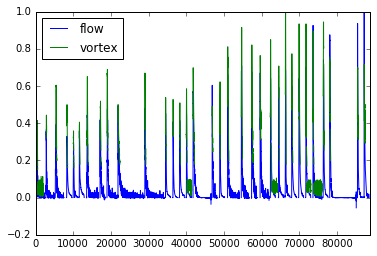

In [22]:
(df[['flow','vortex']]/df[['flow','vortex']].max()).plot()

In [23]:
df_grouped = df.groupby('meta')

6
6
10
9
2
3
3


meta
Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)          6
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)    10
Sidestack (Purple 2)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)      9
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)     2
Sidestack (Purple 4)Downstream D (Yellow)Mouthpiece E (Black)0% Infill (Blue)      3
Sidestack (Purple 8)Downstream D (Yellow)Mouthpiece D (Yellow)0% Infill (Blue)     3
dtype: int64

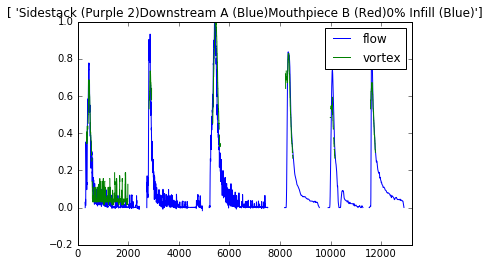

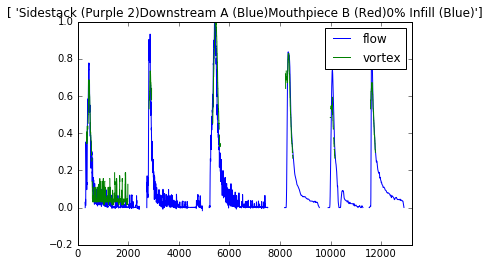

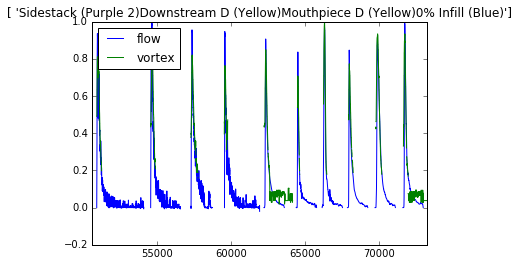

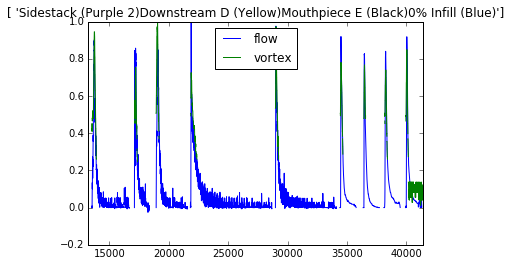

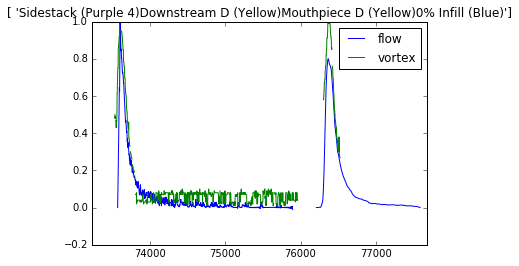

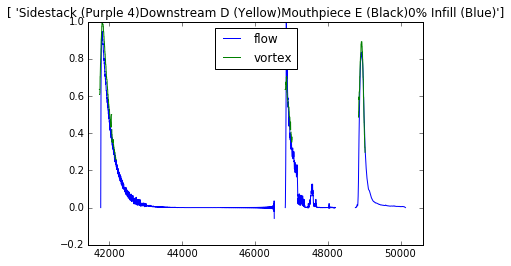

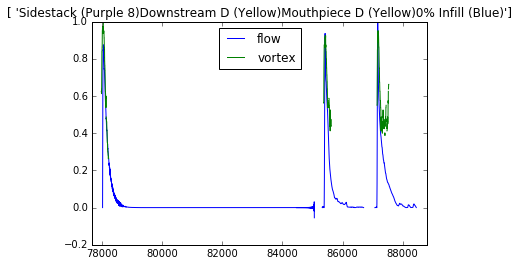

In [24]:
def analyze_groups(grp):
    print len(grp['PWG'].unique())
    plt.figure()
    (grp[['flow','vortex']]/grp[['flow','vortex']].max()).plot()
    plt.title(grp.meta.unique())
    return len(grp['PWG'].unique())
    
df_result = df_grouped.apply(analyze_groups)
df_result

In [16]:
def analyze_groups(grp):
    yhats = []
    for grp_pwg in grp['PWG'].unique():
        df_test = grp[grp['PWG']==grp_pwg]
        df_train = grp[grp['PWG']!=grp_pwg]
        
        
        
        X = df_train[['vortex','side_f','side_h1']].values
        y = df_train.flow.values
        
        Xtest = df_test[['vortex','side_f','side_h1']].values
        ytest = df_test.flow.values
        
        reg = lm.LinearRegression()
        yhat = reg.fit(X,y).predict(Xtest)
        yhats.append((yhat,ytest))
    
    return yhats
    
df_result = df_grouped.apply(analyze_groups)
df_result

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

301 560
10 0.933333333333
0.933333333333 @ 304 : 334
0.933333333333 @ 303 : 333
0.933333333333 @ 302 : 332
0.933333333333 @ 301 : 331
0.933333333333 @ 300 : 330
Breaking at 330  because NaN was found


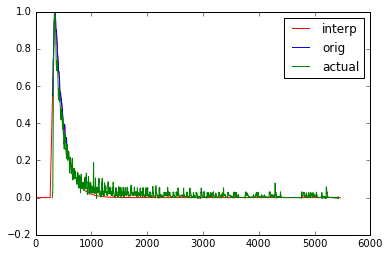

In [495]:
from scipy.interpolate import interp1d 
from scipy.signal import medfilt
def nan_interp(y):
    y = np.copy(y)
    y[0]=0.0
    y[1]=0.0
    y[-1] = 0.0
    y[-2] = 0.0
    x = np.array(range(len(y)))
    peak_idx = np.nanargmax(y)
    peak = np.nanmax(y)
    
    nans = np.isnan(y)
    
    first_finite = 0
    last_finite = len(nans) - 1
    
    for i in range(2, len(nans)):
        if nans[i] == False:
            first_finite = i
            break
    
    for i in range(len(nans) - 3, 0, -1):
        if nans[i] == False:
            last_finite = i
            break
            
    print first_finite, last_finite
    
    # MID
    x_mid = x[first_finite + 1 : last_finite]
    y_mid = y[first_finite + 1 : last_finite]
    nans_mid = nans[first_finite + 1 : last_finite]
    
    f_mid = interp1d(x_mid[~nans_mid], y_mid[~nans_mid], kind = 1)
    y_mid[nans_mid] = f_mid(x_mid[nans_mid])
    
    # Replace y (at mid) with the new interpolated y_mid values
    y[first_finite + 1 : last_finite] = y_mid
    
    
    # FRONT
    y, zeros_added = fit_head(y, peak_idx, first_finite)
    
    
    # BACK
    y = fit_tail(exponential_tail, np.copy(y), peak_idx, len(y))

    return y
    

PWG = df.PWG[5000*6]
y = np.copy(df[df.PWG==PWG]['vortex'].values)
flow = np.copy(df[df.PWG==PWG]['flow'].values)
# ynew = y
ynew = nan_interp(np.copy(y))

plt.plot(ynew/ynew.max(),'r',label='interp')
plt.plot(y/np.nanmax(y), label='orig')
plt.plot(flow/np.nanmax(flow), 'g', label='actual')
plt.legend()

In [494]:
from scipy import optimize


def linear_mix( start, end ):
    mix = np.linspace(1, 0, len(start))
    return mix * start + (1 - mix) * end

# We use no offset, e.g. we asymptotically approach zero
def exponential_tail(x, a0, a1, b0, b1):
    return a0 * np.exp(-b0*x) + a1 * np.exp(-b1*x*x)

def expexp_tail(x, a0, b0):
    return a0 * np.exp(np.exp(-b0*x))

def make_p0(tail_model, a, b):
    if tail_model == exponential_tail:
        return [a, a, b, b]
    if tail_model == expexp_tail:
        return [a, b]
    return None

# Given a signal x, with tail x[start_idx:end_idx], fit the funciton tail_model
# (which should be exponential_tail, or expexp_tail) to the tail, and modify x
# such that it decays according to tail_model.  Return x
def fit_tail( tail_model, x, start_idx, end_idx, mixfunc=linear_mix ):
    x = np.copy(x)
    x_tail = x[start_idx:end_idx+(end_idx-start_idx)/10]
    a = x_tail[0]
    b = 0.01
    
    nans = np.isnan(x_tail)
    xx = np.array(range(len(x_tail)))
    popt, pcov = optimize.curve_fit(tail_model, xx[~nans], x_tail[~nans], p0=make_p0(tail_model, a, b))

    
    gen_tail = exponential_tail(np.arange(len(x) - start_idx), *popt)
    x_tail[nans] = gen_tail[nans]
    x[start_idx:end_idx+(end_idx-start_idx)/10] = x_tail
    x[start_idx:end_idx] = mixfunc(x[start_idx:end_idx], gen_tail[:end_idx-start_idx])
    x[end_idx:] = gen_tail[end_idx-start_idx:]
    return x

# P_t = np.linspace(1,5,500).T
# P_f = np.sin(P_t)+1

# # Find peak index
# peak_idx = np.nanargmax(P_f)
# avg_dt = np.mean(np.diff(P_t))

# P_fnew = fit_tail(exponential_tail, P_f, peak_idx, len(P_f))

# plt.plot(P_t, P_f, label='orig')
# plt.plot(P_t, P_fnew, label='new')
# plt.legend()



def fit_head(y, peak_idx, first_finite):
    # Create a copy of x so the original isn't modified
    y = np.copy(y)
    # Shift peak_idx so the first slope is actually steep
#     peak_idx = np.copy(peak_idx) - 10
    
    # Define slope window
    window = 30
    start_idx = int(0.25 * (peak_idx - first_finite))
    for i in range(start_idx, 0, -1):
        start_slope = np.nanmean(np.diff(y[peak_idx - i - window : peak_idx - i + 1]))
        if start_slope > 0:
            print i, start_slope
            peak_idx = peak_idx - i
            break
            
    if start_slope <= 0:
        start_slope = np.nanmean(np.diff(y[peak_idx - 10 : peak_idx + 1]))
    
    print start_slope, '@', peak_idx - window, ':', peak_idx
    
    last_valid = peak_idx - 1
    
    # Iterate backwards from peak to find last valuable slope
    for i in range(peak_idx - 1, 0, -1):
        # Get new window
        ytmp = y[i - window : i + 1]
        print start_slope, '@', i - window, ':', i
        # If any values in the window are NaN, we've gone too far... break
        if np.isnan(ytmp).any():
            print 'Breaking at', i, ' because NaN was found'
            last_valid = i
            break
        
        # Get new slope
        slope =  np.nanmean(np.diff(ytmp))
        
        # Compare new slope against last slope. If diff is > th %, break and use last slope value
        th = -.1
#         if np.abs(slope-start_slope)/float(start_slope)>th:
        if slope - start_slope < th or slope <= 0:
            print 'Breaking at', i, ' because slope diff exceeded thresh', slope, start_slope
            last_valid = i
            break    
        elif slope > start_slope:
#         else:
            start_slope = slope
    
    # Calc. the width required for the curve to reach 0 from peak
    
    front_width = int(np.ceil(y[last_valid]/start_slope))

    # Check to see if peak_idx - start_width occurs before the beginning of x
    num_zeros_added = 0
    if last_valid - front_width < 0:
        num_zeros_added = front_width - last_valid
        # push difference worth of zeros onto front
        y = np.hstack((np.zeros(front_width - last_valid), y))
        # move peak_idx to updated location
        last_valid += front_width - last_valid

    # From where the curve should be 0 (which may be at x[0] or later), replace values with
    # ... values from approximated slope curve
#     print front_width
    y[last_valid - front_width : last_valid + 1] = np.linspace(0, y[last_valid], front_width + 1)

    # Zero out everything before as well
    y[ : last_valid - front_width] = 0
    return y, num_zeros_added

In [377]:
np.nanmean([np.nan,np.nan,np.nan,np.nan,np.nan,])>0

False